In [1]:
import wrf
from wrf import getvar, ALL_TIMES, latlon_coords
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import datetime
from datetime import datetime, timedelta
# import nc_time_axis
# from cftime import DatetimeNoLeap
import numpy as np
import xarray as xr
from braceexpand import braceexpand
import pandas as pd
import time
%matplotlib inline
%config InlineBackend.figure_format='retina'


### Functions

In [2]:
# Purpose: To alliviate the memory issue that arrises when you getvar() a big dataset.
# Input:
    # xrDataset = xr.open_dataset(filepath)
    # Dataset = Dataset(filepath)
    # varname = '<variablename>'
# Output:
    # da: This will be the xr.DataArray you are after
# Process:
    # First create an empty np.array that holds varname values.
    # Loop through each timestep to fill in the np.array.
    # Here's the trick, only getvar() one timestep, then expand the time dim.
        # This will repeate the values from the first timestep into the Time dim.
    # Assign the Time coordinates.
    # Replace the repeated values with the correct values from npArray.

# This method is ~6x more efficient than getvar(Dataset, varname, ALL_TIMES)

def wrf_np2da(xrDataset,Dataset,varname):
    da_times = getvar(Dataset, 'times', ALL_TIMES)			# Times in datetime64
    # Create empty numpy array
    npArray = np.empty((xrDataset.dims['Time'],xrDataset.dims['bottom_top'],
                        xrDataset.dims['south_north'],xrDataset.dims['west_east']),np.float32)
    for i in range(npArray.shape[0]):
        npArray[i,...] = getvar(Dataset, varname, timeidx=i, meta=False)
    da = getvar(Dataset, varname, timeidx=0)
    da = da.expand_dims(dim={'Time': da_times}, axis=0)
    da = da.assign_coords(dict(
        Time=('Time',da_times.values),
        XTIME=('Time',np.float32(xrDataset['ITIMESTEP'].values))
    ))
    da.values = npArray
    return da

In [3]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.

def assign_LT_coord(da):
	hour_offset = (da.XLONG.values[:,0,:]/15).round(decimals=0)
	local_time = np.empty([len(da.Time),len(da.west_east)], dtype=object)
	for i in range(local_time.shape[0]):
		for j in range(local_time.shape[1]):
			local_time[i,j] = da.XTIME.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
	da = da.assign_coords(LocalTime=(('Time','west_east'),local_time))
	return da

In [4]:
def da_info(da):
    print('Description: ', da.description, '\nUnits: ',da.units, '\nDimensions: ', da.dims, '\nShape: ', da.shape)

### Read in variables


In [5]:
parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/6day-2015-11-22-12--28-12/'
file_d01_raw = parent_dir + 'raw/d01'
file_d02_raw = parent_dir + 'raw/d02'
file_d01_RR = parent_dir + 'L1/d01_RR'				# [mm/dt]
file_d02_RR = parent_dir + 'L1/d02_RR'				# [mm/dt]
file_d01_LWUPT = parent_dir + 'L1/d01_LWUPT'	    # [W/m^2]
file_d02_LWUPT = parent_dir + 'L1/d02_LWUPT'	    # [W/m^2]
file_d01_U850 = parent_dir + 'L2/d01_interp_U850'	# [m/s]
file_d02_U850 = parent_dir + 'L2/d02_interp_U850'	# [m/s]
file_d01_U200 = parent_dir + 'L2/d01_interp_U200'	# [m/s]
file_d02_U200 = parent_dir + 'L2/d02_interp_U200'	# [m/s]

# Raw datasets
start_time = time.perf_counter()
ds_d01 = xr.open_dataset(file_d01_raw)  # Used for .sel()
ds_d02 = xr.open_dataset(file_d02_raw)  # Used for .sel()
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')

# Coordinate dictionaries:
step2_time = time.perf_counter()
d01_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d01.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d01.XLONG.values),
    XTIME=('Time',ds_d01.XTIME.values)
    )
d02_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
    XTIME=('Time',ds_d02.XTIME.values)
    )
step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')

# 850 hPa zonal winds
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_U850)
da_d01_U850 = ds['U'].compute().squeeze()
da_d01_U850 = da_d01_U850.assign_coords(d01_coords)
fill_value = da_d01_U850.max()      # This is the fill_value meaning missing_data
da_d01_U850 = da_d01_U850.where(da_d01_U850!=fill_value)    # Change fill_value points to nans
ds = xr.open_dataset(file_d02_U850)
da_d02_U850 = ds['U'].compute().squeeze()
da_d02_U850 = da_d02_U850.assign_coords(d02_coords)
da_d02_U850 = da_d02_U850.where(da_d02_U850!=fill_value)    # Change fill_value points to nans
step1_time = time.perf_counter()
print('850 hPa zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# 200 hPa zonal winds
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_U200)
da_d01_U200 = ds['U'].compute().squeeze()
da_d01_U200 = da_d01_U200.assign_coords(d01_coords)
fill_value = da_d01_U200.max()      # This is the fill_value meaning missing_data
da_d01_U200 = da_d01_U200.where(da_d01_U200!=fill_value)    # Change fill_value points to nans
ds = xr.open_dataset(file_d02_U200)
da_d02_U200 = ds['U'].compute().squeeze()
da_d02_U200 = da_d02_U200.assign_coords(d02_coords)
da_d02_U200 = da_d02_U200.where(da_d02_U200!=fill_value)    # Change fill_value points to nans
step1_time = time.perf_counter()
print('200 hPa zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Rain Rate     [mm/hr]
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_RR)
da_d01_RR = ds['RR'].compute()
da_d01_RR = da_d01_RR.assign_coords(d01_coords)
ds = xr.open_dataset(file_d02_RR)
da_d02_RR = ds['RR'].compute()
da_d02_RR = da_d02_RR.assign_coords(d02_coords)
step1_time = time.perf_counter()
print('Rain rates loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Instantaneous Longwave Upwelling Flux at Top (LWUPT) [W/m^2]
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_LWUPT)
da_d01_LWUPT = ds['LWUPT'].compute()
da_d01_LWUPT = da_d01_LWUPT.assign_coords(d01_coords)
ds = xr.open_dataset(file_d02_LWUPT)
da_d02_LWUPT = ds['LWUPT'].compute()
da_d02_LWUPT = da_d02_LWUPT.assign_coords(d02_coords)
step1_time = time.perf_counter()
print('Longwave Upwelling Flux at TOA loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Detection of land & water
step2_time = time.perf_counter()
da_d01_LANDMASK = ds_d01['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
step1_time = time.perf_counter()
print('Landmask loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Temporal and Spatial variables
step2_time = time.perf_counter()
da_d01_XTIME = da_d01_LANDMASK.XTIME						# Times in datetime64 [hourly]
da_d02_XTIME = da_d02_LANDMASK.XTIME						# Times in datetime64 [hourly]
da_d01_LATS, da_d01_LONGS = wrf.latlon_coords(da_d01_LANDMASK)	# Lat & Lon [degrees]
da_d02_LATS, da_d02_LONGS = wrf.latlon_coords(da_d02_LANDMASK)	# Lat & Lon [degrees]
step1_time = time.perf_counter()
print('Tempospatial variables loaded \N{check mark}', step1_time-step2_time, 'seconds')

print('Domain d01 & d02 \N{check mark}', step1_time-start_time, 'seconds')

Dataset loaded ✓ 1.9916019281372428 seconds
Created coordinate dictionaries ✓ 22.63493975996971 seconds
850 hPa zonal winds loaded ✓ 7.977015187963843 seconds
200 hPa zonal winds loaded ✓ 2.6407868177630007 seconds
Rain rates loaded ✓ 5.0469881570898 seconds
Longwave Upwelling Flux at TOA loaded ✓ 1.6539575080387294 seconds
Landmask loaded ✓ 0.019258798100054264 seconds
Tempospatial variables loaded ✓ 0.00039633410051465034 seconds
Domain d01 & d02 ✓ 41.966310212854296 seconds


#### Add Local Time Coordinate

In [6]:
# d01
da_d01_U850 = assign_LT_coord(da_d01_U850)
da_d01_U200 = assign_LT_coord(da_d01_U200)
da_d01_RR = assign_LT_coord(da_d01_RR)
da_d01_LWUPT = assign_LT_coord(da_d01_LWUPT)

# d02
da_d02_U850 = assign_LT_coord(da_d02_U850)
da_d02_U200 = assign_LT_coord(da_d02_U200)
da_d02_RR = assign_LT_coord(da_d02_RR)
da_d02_LWUPT = assign_LT_coord(da_d02_LWUPT)

#### LANDMASK vs XLAND

In [ ]:
# x = da_d02_XLAND[0,:,:].where((da_d02_LANDMASK[0,:,:]==1)&(da_d02_XLAND[0,:,:]==1),drop=False)
# x
# cf1 = x.plot.contourf(
# 	cmap='RdBu_r',		# _r reverses the colorbar order!
# )
# da_d02_LANDMASK = ds_d02['LANDMASK'].sel().compute()	# Land = 1, Water = 0
# da_d02_XLAND = ds_d02['XLAND'].sel().compute()	# Land = 1, Water = 0

# fig = plt.figure(figsize=(11,4.5))
# gs = gridspec.GridSpec(nrows=1, ncols=2, hspace=0.075)

# ax1 = fig.add_subplot(gs[0,0])
# cf1 = da_d02_LANDMASK[0,300:400,100:200].plot.contourf(
# 	cmap='RdBu_r',		# _r reverses the colorbar order!
    
# )
# ax1 = fig.add_subplot(gs[0,1])
# cf1 = da_d02_XLAND[0,300:400,100:200].plot.contourf(
# 	cmap='RdBu',		# _r reverses the colorbar order!
# )

### Set global variables
Anything that will be used throughout the script should be assigned here.

In [7]:
# Set the bounds you want to look at
lat_bound = [-5,5]		# South to North
lon_bound_d01 = [80,135]	# West to East
lon_bound_d02 = [90,125]	# West to East

# Hovmoller diagram (d01)

### Rain + 850hPa zonal winds

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d01_RR.where(
    (da_d01_RR.XLAT>lat_avg_bound[0]) & (da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x1 = x1.set_index(Time='XTIME')

# Isolate and average the 850 hPa zonal winds between the lat_avg_bounds
x2 = da_d01_U850.where(
    (da_d01_U850.XLAT>lat_avg_bound[0]) & (da_d01_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
# Apply a rolling center mean for zonal winds to smooth it out
x2 = x2.rolling(Time=4*2, min_periods=1, center=True).mean()
x2 = x2.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x2 = x2.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the zonal winds
cf1 = x2.plot.contourf(
	# x = 'west_east',
    # y = 'Time',
    ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray',
	levels=np.arange(20,75,5),
	vmin=20, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### Rain

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF d01 Rain rate', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d01_RR.where(
    (da_d01_RR.XLAT>lat_avg_bound[0]) & (da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x1 = x1.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray_r',
	levels=np.arange(0,75,5),
	# levels=np.append(0,np.logspace(0,2,15)),
	vmin=0, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('WRF Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### 850hPa zonal winds

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the 850 hPa zonal winds between the lat_avg_bounds
x2 = da_d01_U850.where(
    (da_d01_U850.XLAT>lat_avg_bound[0]) & (da_d01_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
# Apply a rolling center mean for zonal winds to smooth it out
x2 = x2.rolling(Time=4, min_periods=1, center=True).mean()
x2 = x2.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x2 = x2.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the zonal winds
cf1 = x2.plot.contourf(
	# x = 'west_east',
    # y = 'Time',
    ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, :])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')

# Set titles/labels
ax2.set_title('850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

# Hovmoller Diamgram (d02)

### Rain + 850hPa zonal winds

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,12))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])

x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d02_RR.where(
    (da_d02_RR.XLAT>lat_avg_bound[0]) & (da_d02_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d02.XLONG.values[0,0,:]))
x1 = x1.set_index(Time='XTIME')

# Isolate and average the 850 hPa zonal winds between the lat_avg_bounds
x2 = da_d02_U850.where(
    (da_d02_U850.XLAT>lat_avg_bound[0]) & (da_d02_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
# Apply a rolling center mean for zonal winds to smooth it out
x2 = x2.rolling(Time=4, min_periods=1, center=True).mean()
x2 = x2.assign_coords(west_east=(['west_east'],ds_d02.XLONG.values[0,0,:]))
x2 = x2.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the zonal winds
cf1 = x2.plot.contourf(
	# x = 'west_east',
    # y = 'Time',
    ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray',
	levels=np.arange(20,75,5),
	vmin=20, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### Rain

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,12))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])

x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF d02 Rain rate', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d02_RR.where(
    (da_d02_RR.XLAT>lat_avg_bound[0]) & (da_d02_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d02.XLONG.values[0,0,:]))
x1 = x1.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray_r',
	levels=np.arange(0,75,5),
	vmin=0, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('WRF Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### 850hPa Zonal Winds

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,12))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])

x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF 850-hPa zonal winds', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the 850 hPa zonal winds between the lat_avg_bounds
x2 = da_d02_U850.where(
    (da_d02_U850.XLAT>lat_avg_bound[0]) & (da_d02_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
# Apply a rolling center mean for zonal winds to smooth it out
x2 = x2.rolling(Time=4, min_periods=1, center=True).mean()
x2 = x2.assign_coords(west_east=(['west_east'],ds_d02.XLONG.values[0,0,:]))
x2 = x2.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the zonal winds
cf1 = x2.plot.contourf(
	# x = 'west_east',
    # y = 'Time',
    ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, :])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')

# Set titles/labels
ax2.set_title('850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### Diurnal Hovmoller Diagram d01

In [ ]:
def hov_diurnal(da):
    # Average over the bounds to create shape of (time,west_east)
    da_avg = da.where((da.XLAT>lat_avg_bound[0])&(da.XLAT<lat_avg_bound[1]),drop=True).mean(dim='south_north')
    # Create a np.array with shape (west_east,hour). Then populate each longitude column with its respective
        # diurnal cycle of rain rate.
    array = np.zeros((da_avg.shape[1],24))
    # Loop through each longitude, look through all the timesteps and group them by hour,
        # and then average the values at each hour. Output the 1x24 array into the empty array
    for i in range(array.shape[0]):
        array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()
    return array

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################



# Composite over the dirunal cycle between latitudes
lat_avg_bound = [-5,5]

# Rain rate
array = hov_diurnal(da_d01_RR)
array = array*24	# Convert to mm/day
# Create the DataArray that holds the np.array you just created
x1 = xr.DataArray(
    data = array,
    dims = ['west_east','hour'],
    coords = dict(
        west_east=('west_east',da_d01_RR.XLONG[0,0,:].values),
        hour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Diurnal Rain Rate',
        units='mm/day')
)

# U-850 winds
array = hov_diurnal(da_d01_U850)
# Create the DataArray that holds the np.array you just created
y1 = xr.DataArray(
    data = array,
    dims = ['west_east','hour'],
    coords = dict(
        west_east=('west_east',da_d01_RR.XLONG[0,0,:].values),
        hour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Diurnal 850-hPa zonal winds',
        units='m/s')
)

########################################
############### PLOTTING ###############
########################################
ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y1.plot.contourf(
    x = 'west_east',
    y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-8,9,1),
	vmin=-8, vmax=8,
	extend='max',
)

# Plot the rain rates
cf2 = x1.plot.contourf(
    x = 'west_east',
    y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray',
	levels=np.arange(16,40,4),
	vmin=16, vmax=36,
	extend='max',
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)

# t = ds_d01.XTIME[12:36:3].dt.strftime('%H:%M')
ax2.set_yticks(y1.hour[0::3])
# ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Local Time')

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

# Composite over the dirunal cycle between latitudes
lat_avg_bound = [-5,5]

# Rain rate
x1 = da_d01_RR.where(
    (da_d01_RR.XLAT>lat_avg_bound[0])&(da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean(dim='south_north')*24
x1 = x1.groupby('XTIME.hour').mean()
x1 = x1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))

# U-850 winds
y1 = da_d01_U850.where(
    (da_d01_U850.XLAT>lat_avg_bound[0]) & (da_d01_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
y1 = y1.groupby('XTIME.hour').mean()
y1 = y1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))

########################################
############### PLOTTING ###############
########################################
ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y1.plot.contourf(
    x = 'west_east',
    y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-8,9,1),
	vmin=-8, vmax=8,
	extend='max',
)

# Plot the rain rates
cf2 = x1.plot.contourf(
    x = 'west_east',
    y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray',
	levels=np.arange(16,40,4),
	vmin=16, vmax=36,
	extend='max',
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)

# t = ds_d01.XTIME[12:36:3].dt.strftime('%H:%M')
ax2.set_yticks(y1.hour[0::3])
# ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('UTC')

In [ ]:
# Ty suggestion
# # UTC
# t = da_d01_P.Time
# # print(t[0],t[-1])
# t = t.values
# t = pd.DatetimeIndex(t)
# b = [cftime.date2num(i,units='hours since 2015-11-24',calendar='standard') for i in t]
# b = np.array(b)
# c = b[:,None,None] + a.values[None]
# c
# d = np.zeros_like(c,dtype=object)
# d.shape

# for i in range(d.shape[1]):
# 	print(i)
# 	for j in range(d.shape[2]):
# 		d[:,i,j] = [cftime.num2date(k,units='hours since 2015-11-24',calendar='standard') for k in c[:,i,j]]
# d

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,12))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])

x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF 850-hPa zonal winds', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

# Composite over the dirunal cycle between latitudes
lat_avg_bound = [-5,5]

# Rain rate
array = hov_diurnal(da_d02_RR)
array = array*24	# Convert to mm/day
# Create the DataArray that holds the np.array you just created
x1 = xr.DataArray(
    data = array,
    dims = ['west_east','hour'],
    coords = dict(
        XLONG=('west_east',da_d02_RR.XLONG[0,0,:].values),
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Diurnal Rain Rate',
        units='mm/day')
)

# # U-850 winds
# array = hov_diurnal(da_d02_U850)
# # Create the DataArray that holds the np.array you just created
# y1 = xr.DataArray(
#     data = array,
#     dims = ['west_east','hour'],
#     coords = dict(
#         XLONG=('west_east',da_d02_RR.XLONG[0,0,:].values),
#         LocalHour=('hour',np.arange(0,24))),
#     attrs=dict(
#         description='Diurnal Rain Rate',
#         units='mm/day')
# )

########################################
############### PLOTTING ###############
########################################
ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
# cf1 = y1.plot.contourf(
# 	ax=ax2,
# 	add_colorbar=False,
# 	xticks=x_ticks,
# 	cmap='RdBu_r',		# _r reverses the colorbar order!
# 	levels=np.arange(-12,13,2),
# 	vmin=-12, vmax=12,
# 	extend='max',
#     x = 'XLONG'
# )

# Plot the rain rates
cf2 = x1.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray',
	levels=np.arange(0,45,5),
	vmin=0, vmax=40,
	extend='max',
    x = 'XLONG'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1)
ax2.grid(linestyle='--', axis='y', linewidth=1)

# Plot the colorbars
	# Zonal wind colorbar
# ax3 = fig.add_subplot(gs[4, 0])
# cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
# cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')


# Set titles/labels
ax2.set_title('Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('')

# ax2.set_xticks(np.arange(lon_bound_d01[0]+15,lon_bound_d01[1],15))
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(x1.hour[0::3])
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Local Time')

### Diurnal average of rain rate over Ocean and Land

In [ ]:
#################### d01 ####################

# LANDMASK (land = 1, water = 0)
########## Land ##########
da = da_d01_RR.where((da_d01_RR.XLAT>lat_bound[0])&(da_d01_RR.XLAT<lat_bound[1])
		     &(da_d01_RR.XLONG>lon_bound_d02[0])&(da_d01_RR.XLONG<lon_bound_d02[1]),drop=False)
da_avg = da.where(da_d01_LANDMASK==1,drop=False).mean(['south_north'], skipna=True)
array = np.zeros((da_avg.shape[1],24))
# Loop through each longitude, look through all the timesteps and group them by hour,
	# and then average the values at each hour. Output the 1x24 array into the empty/zero array
for i in range(array.shape[0]):
	array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()

# Create a weighted array that takes into account the number of land hits/Trues at each longitude
	# in order to weight the diurnal signal appropriately. This is to avoid weighting a longitude
    # with a few land hits with a longitude that has hundreds of hits.
# Gives the number of land hits at each longitude
w = da_d01_LANDMASK.where(da_d01_LANDMASK==1,drop=False).sum('south_north')
w = w.values/w.values.sum()     # divide by the total land hits for a weight at each longitude
# Multiply each diurnal signal (24 hours) with the weight respective to each longitude grid
a = np.multiply(array.transpose(),w).transpose()
# Sum together normalized diurnal cycle at each longitude to get the average diurnal cycle over land
a = np.nansum(a,axis=0) * 24	# Convert to mm/day
x1 = xr.DataArray(
    data = a,
    dims = ['hour'],
    coords = dict(
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Average Rain Rate Diurnal Cycle over LAND',
        units='mm/day')
)

########## Ocean ##########
da = da_d01_RR.where((da_d01_RR.XLAT>lat_bound[0])&(da_d01_RR.XLAT<lat_bound[1])
		     &(da_d01_RR.XLONG>lon_bound_d02[0])&(da_d01_RR.XLONG<lon_bound_d02[1]),drop=False)
da_avg = da.where(da_d01_LANDMASK==0,drop=False).mean(['south_north'], skipna=True)
array = np.zeros((da_avg.shape[1],24))
# Loop through each longitude, look through all the timesteps and group them by hour,
	# and then average the values at each hour. Output the 1x24 array into the empty array
for i in range(array.shape[0]):
	array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()

# Create a weighting array that takes into account the number of land hits at each longitude
	# in order to weight the diurnal signal appropriately
w = da_d01_LANDMASK.where(da_d01_LANDMASK==1,drop=False).sum('south_north')
w = w.values/w.values.sum()
# Multiply each diurnal signal (24 hours) with the weight respective to each longitude grid
a = np.multiply(array.transpose(),w).transpose()
# Sum together normalized diurnal cycle at each longitude to get the average diurnal cycle over OCEAN
a = np.nansum(a,axis=0) * 24	# Convert to mm/day
x2 = xr.DataArray(
    data = a,
    dims = ['hour'],
    coords = dict(
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Average Rain Rate Diurnal Cycle over OCEAN',
        units='mm/day')
)

###########################
########### PLOT ##########
###########################

# fig = plt.figure(figsize=(11,4.5))
# ax1 = fig.add_subplot()

# a = x1.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     color='peru',
#     linewidth=2,
#     linestyle = '-'
# )
# b = x2.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-'
# )

# ax1.grid(linestyle='--', axis='x', linewidth=1)
# # ax1.grid(linestyle='--', axis='y', linewidth=1)
# # Set titles/labels
# ax1.set_title('WRF-Diurnal Rain Rate [5°S-5°N]', loc='left', fontsize=10)
# ax1.set_title('Time Range: Nov-22--28', loc='right', fontsize=10)
# ax1.set_title('')

# ax1.set_xticks(np.arange(0,24,3))
# # ax2.set_yticklabels(t.values)
# ax1.set_xlabel('Local Hour')
# ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
# ax1.legend(['Land-d01','Ocean-d01'])


In [ ]:
#################### d02 ####################

# LANDMASK (land = 1, water = 0)
########## Land ##########
da = da_d02_RR.where((da_d02_RR.XLAT>lat_bound[0])&(da_d02_RR.XLAT<lat_bound[1]),drop=False)
da_avg = da.where(da_d02_LANDMASK==1,drop=False).mean(['south_north'], skipna=True)
array = np.zeros((da_avg.shape[1],24))
# Loop through each longitude, look through all the timesteps and group them by hour,
	# and then average the values at each hour. Output the 1x24 array into the empty/zero array
for i in range(array.shape[0]):
	array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()

# Create a weighted array that takes into account the number of land hits/Trues at each longitude
	# in order to weight the diurnal signal appropriately. This is to avoid weighting a longitude
    # with a few land hits with a longitude that has hundreds of hits.
# Gives the number of land hits at each longitude
w = da_d02_LANDMASK.where(da_d02_LANDMASK==1,drop=False).sum('south_north')
w = w.values/w.values.sum()     # divide by the total land hits for a weight at each longitude
# Multiply each diurnal signal (24 hours) with the weight respective to each longitude grid
a = np.multiply(array.transpose(),w).transpose()
# Sum together normalized diurnal cycle at each longitude to get the average diurnal cycle over land
a = np.nansum(a,axis=0) * 24	# Convert to mm/day
y1 = xr.DataArray(
    data = a,
    dims = ['hour'],
    coords = dict(
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Average Rain Rate Diurnal Cycle over LAND',
        units='mm/day')
)

########## Ocean ##########
da = da_d02_RR.where((da_d02_RR.XLAT>lat_bound[0])&(da_d02_RR.XLAT<lat_bound[1]),drop=False)
da_avg = da.where(da_d02_LANDMASK==0,drop=False).mean(['south_north'], skipna=True)
array = np.zeros((da_avg.shape[1],24))
# Loop through each longitude, look through all the timesteps and group them by hour,
	# and then average the values at each hour. Output the 1x24 array into the empty array
for i in range(array.shape[0]):
	array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()

# Create a weighting array that takes into account the number of land hits at each longitude
	# in order to weight the diurnal signal appropriately
w = da_d02_LANDMASK.where(da_d02_LANDMASK==1,drop=False).sum('south_north')
w = w.values/w.values.sum()
# Multiply each diurnal signal (24 hours) with the weight respective to each longitude grid
a = np.multiply(array.transpose(),w).transpose()
# Sum together normalized diurnal cycle at each longitude to get the average diurnal cycle over OCEAN
a = np.nansum(a,axis=0) * 24	# Convert to mm/day
y2 = xr.DataArray(
    data = a,
    dims = ['hour'],
    coords = dict(
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Average Rain Rate Diurnal Cycle over OCEAN',
        units='mm/day')
)

###########################
########### PLOT ##########
###########################

# fig = plt.figure(figsize=(11,4.5))
# ax1 = fig.add_subplot()

# a = y1.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     color='peru',
#     linewidth=2,
#     linestyle = '-'
# )
# b = y2.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-'
# )

# ax1.grid(linestyle='--', axis='x', linewidth=1)
# # ax1.grid(linestyle='--', axis='y', linewidth=1)
# # Set titles/labels
# ax1.set_title('WRF-Diurnal Rain Rate [5°S-5°N]', loc='left', fontsize=10)
# ax1.set_title('Time Range: Nov-22--28', loc='right', fontsize=10)
# ax1.set_title('')

# ax1.set_xticks(np.arange(0,24,3))
# # ax2.set_yticklabels(t.values)
# ax1.set_xlabel('Local Hour')
# ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
# ax1.legend(['Land-d02','Ocean-d02'])


In [ ]:
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x1.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='peru',
    linewidth=2,
    linestyle = '-'
)
b = x2.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='dodgerblue',
    linewidth=2,
    linestyle = '-'
)
c = y1.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='peru',
    linewidth=2,
    linestyle = '--'
)
d = y2.plot.line(
    ax=ax1,
    xlim=[0,23],
    ylim=[0,35],
    color='dodgerblue',
    linewidth=2,
    linestyle = '--'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
# ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('WRF-Diurnal Rain Rate [5°S-5°N, 90°-125°E]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov-22--28', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(np.arange(0,24,3))
# ax2.set_yticklabels(t.values)
ax1.set_xlabel('Local Hour')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(['Land-d01','Ocean-d01','Land-d02','Ocean-d02'])


In [ ]:
# d01
x1 = da_d01_RR.where(
    (da_d01_RR.XLAT>lat_avg_bound[0]) & (da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north').mean('west_east')*24

# d02
x2= da_d02_RR.where(
    (da_d02_RR.XLAT>lat_avg_bound[0]) & (da_d02_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north').mean('west_east')*24

fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x1.plot.line(
    ax=ax1,
    xlim=[0,x1.shape[0]-1],
    # x_ticks=x1.XTIME,
    color='peru',
    linewidth=2,
    linestyle = '-',
)
b = x2.plot.line(
    ax=ax1,
    # xlim=[0,23],
    ylim=[0,20],
    color='dodgerblue',
    linewidth=2,
    linestyle = '-'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('WRF-Large-Scale Rain Rate Evolution [5°S-5°N]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov-22--28', loc='right', fontsize=10)
ax1.set_title('')

# ax1.set_xticks(np.arange(0,24,3))
# ax2.set_yticklabels(t.values)
# t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax1.set_xticks(x1.Time[12::24])
ax1.set_xticklabels(np.array(x1.XTIME[12::24].dt.strftime("%Y-%m-%d")))
ax1.set_xlabel('')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(['d01','d02'], loc='upper right')


In [ ]:
# d01
x1 = da_d01_RR.where(
    (da_d01_RR.XLAT>lat_avg_bound[0]) & (da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north').mean('west_east')*24
x1 = x1 - x1.mean('Time')

# d02
x2= da_d02_RR.where(
    (da_d02_RR.XLAT>lat_avg_bound[0]) & (da_d02_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north').mean('west_east')*24
x2 = x2 - x2.mean('Time')


fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x1.plot.line(
    ax=ax1,
    xlim=[0,x1.shape[0]-1],
    # x_ticks=x1.XTIME,
    color='peru',
    linewidth=2,
    linestyle = '-',
)
b = x2.plot.line(
    ax=ax1,
    # xlim=[0,23],
    ylim=[-15,15],
    color='dodgerblue',
    linewidth=2,
    linestyle = '-'
)
plt.axhline(y = 0, color = 'k', linestyle = '-')

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('WRF-Large-Scale Rain Rate Evolution [5°S-5°N]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov-22--28', loc='right', fontsize=10)
ax1.set_title('')

# ax1.set_xticks(np.arange(0,24,3))
# ax2.set_yticklabels(t.values)
# t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax1.set_xticks(x1.Time[12::24])
ax1.set_xticklabels(np.array(x1.XTIME[12::24].dt.strftime("%Y-%m-%d")))
ax1.set_xlabel('')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(['d01','d02'], loc='upper right')


In [19]:
lon_bound_d02
# lat_bound

[90, 125]

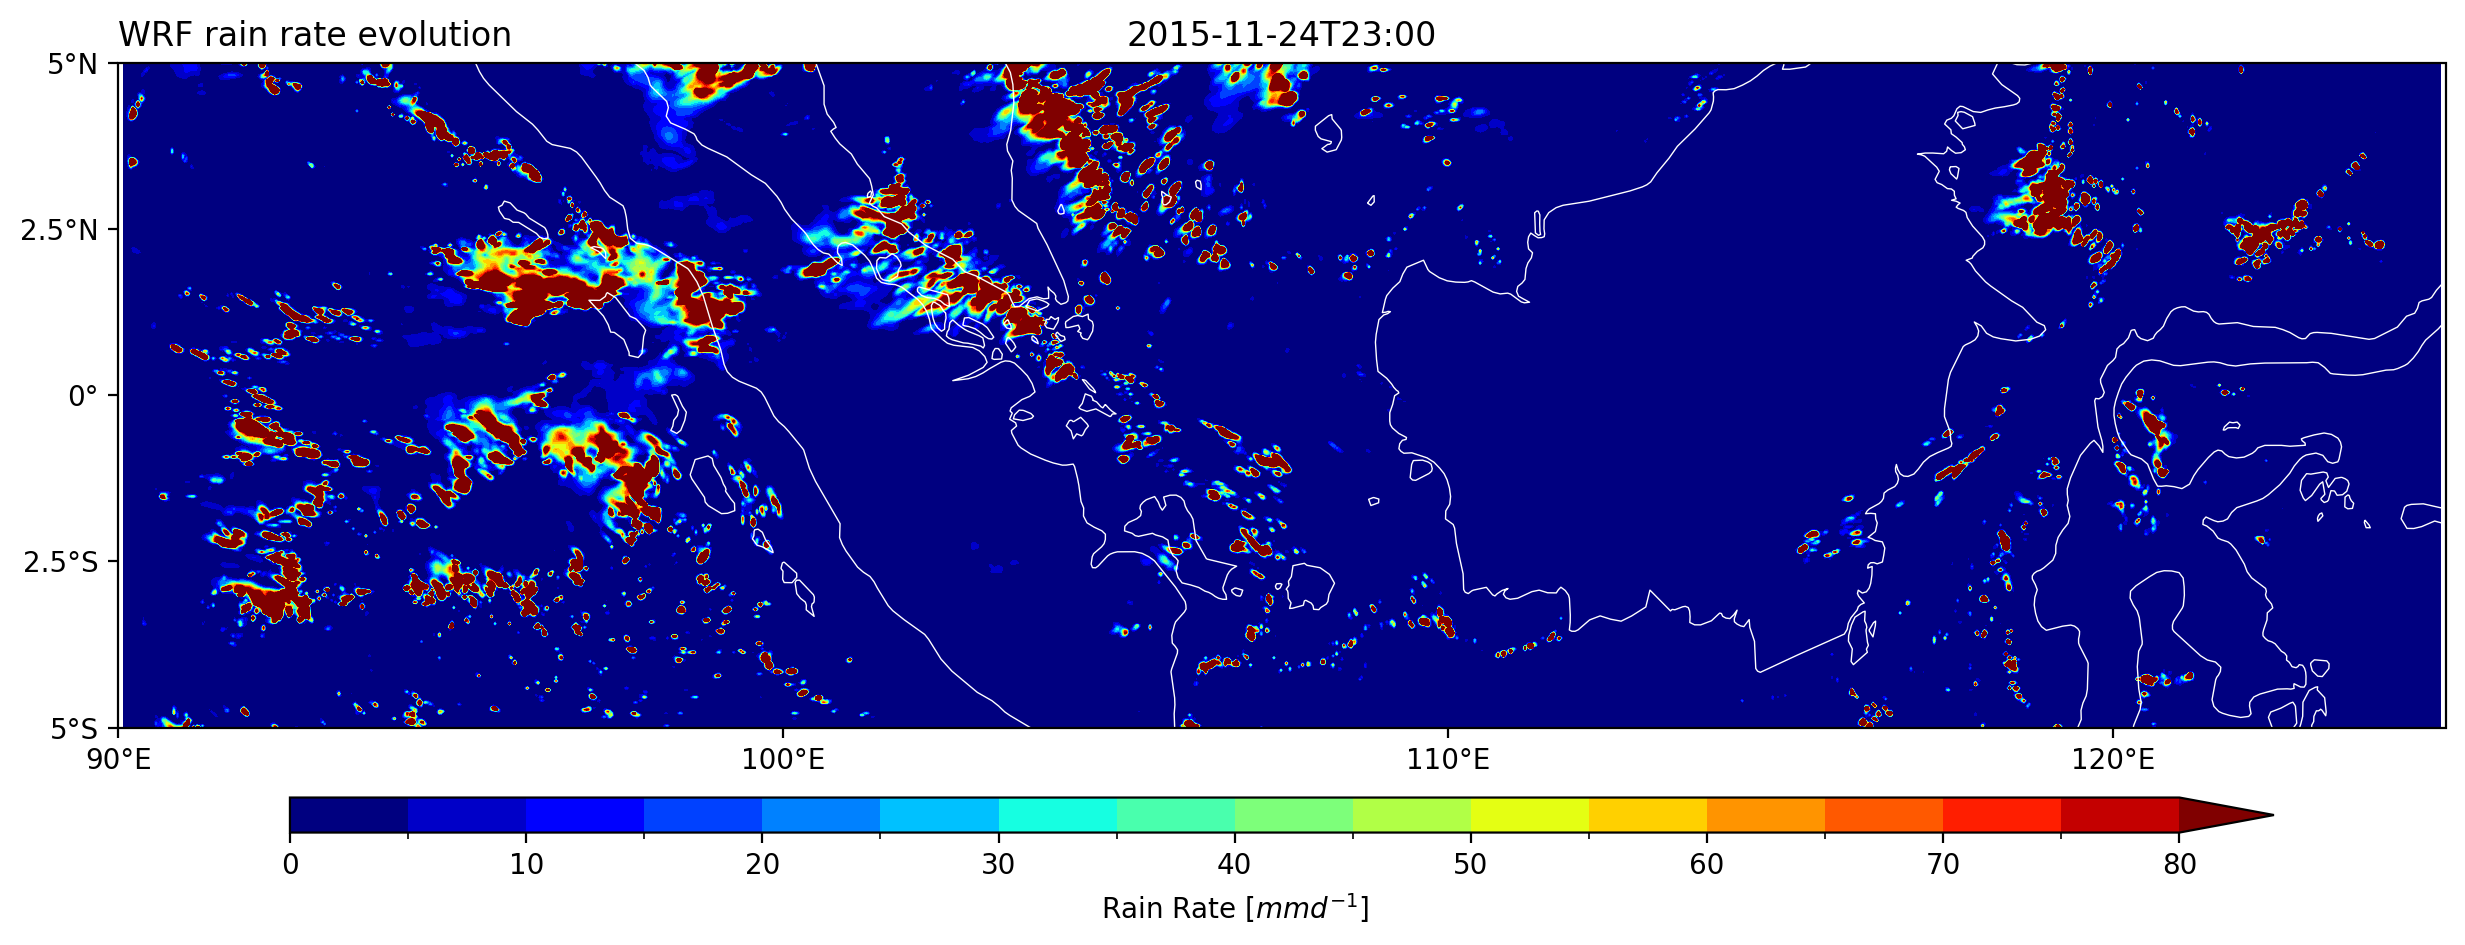

In [33]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
lat_avg_bound = [-5,5]
# Data
x = da_d02_RR[36:60,...].where(
    (da_d02_RR[36:60,...].XLAT>lat_avg_bound[0]) & (da_d02_RR[36:60,...].XLAT<lat_avg_bound[1]),
    drop=True)*24    # mm/day

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='w', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [0,85]
dl = 5


cf = x[0,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
    )


ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')

for i in range(24):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
        ) 
    ax1.set_title('WRF rain rate evolution',loc='left')
    ax1.set_title(np.datetime_as_string(x.XTIME[i],unit='m'))
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    plt.savefig('plots/WRF'+np.datetime_as_string(x.XTIME[i],unit='m')+'.png',dpi=300)


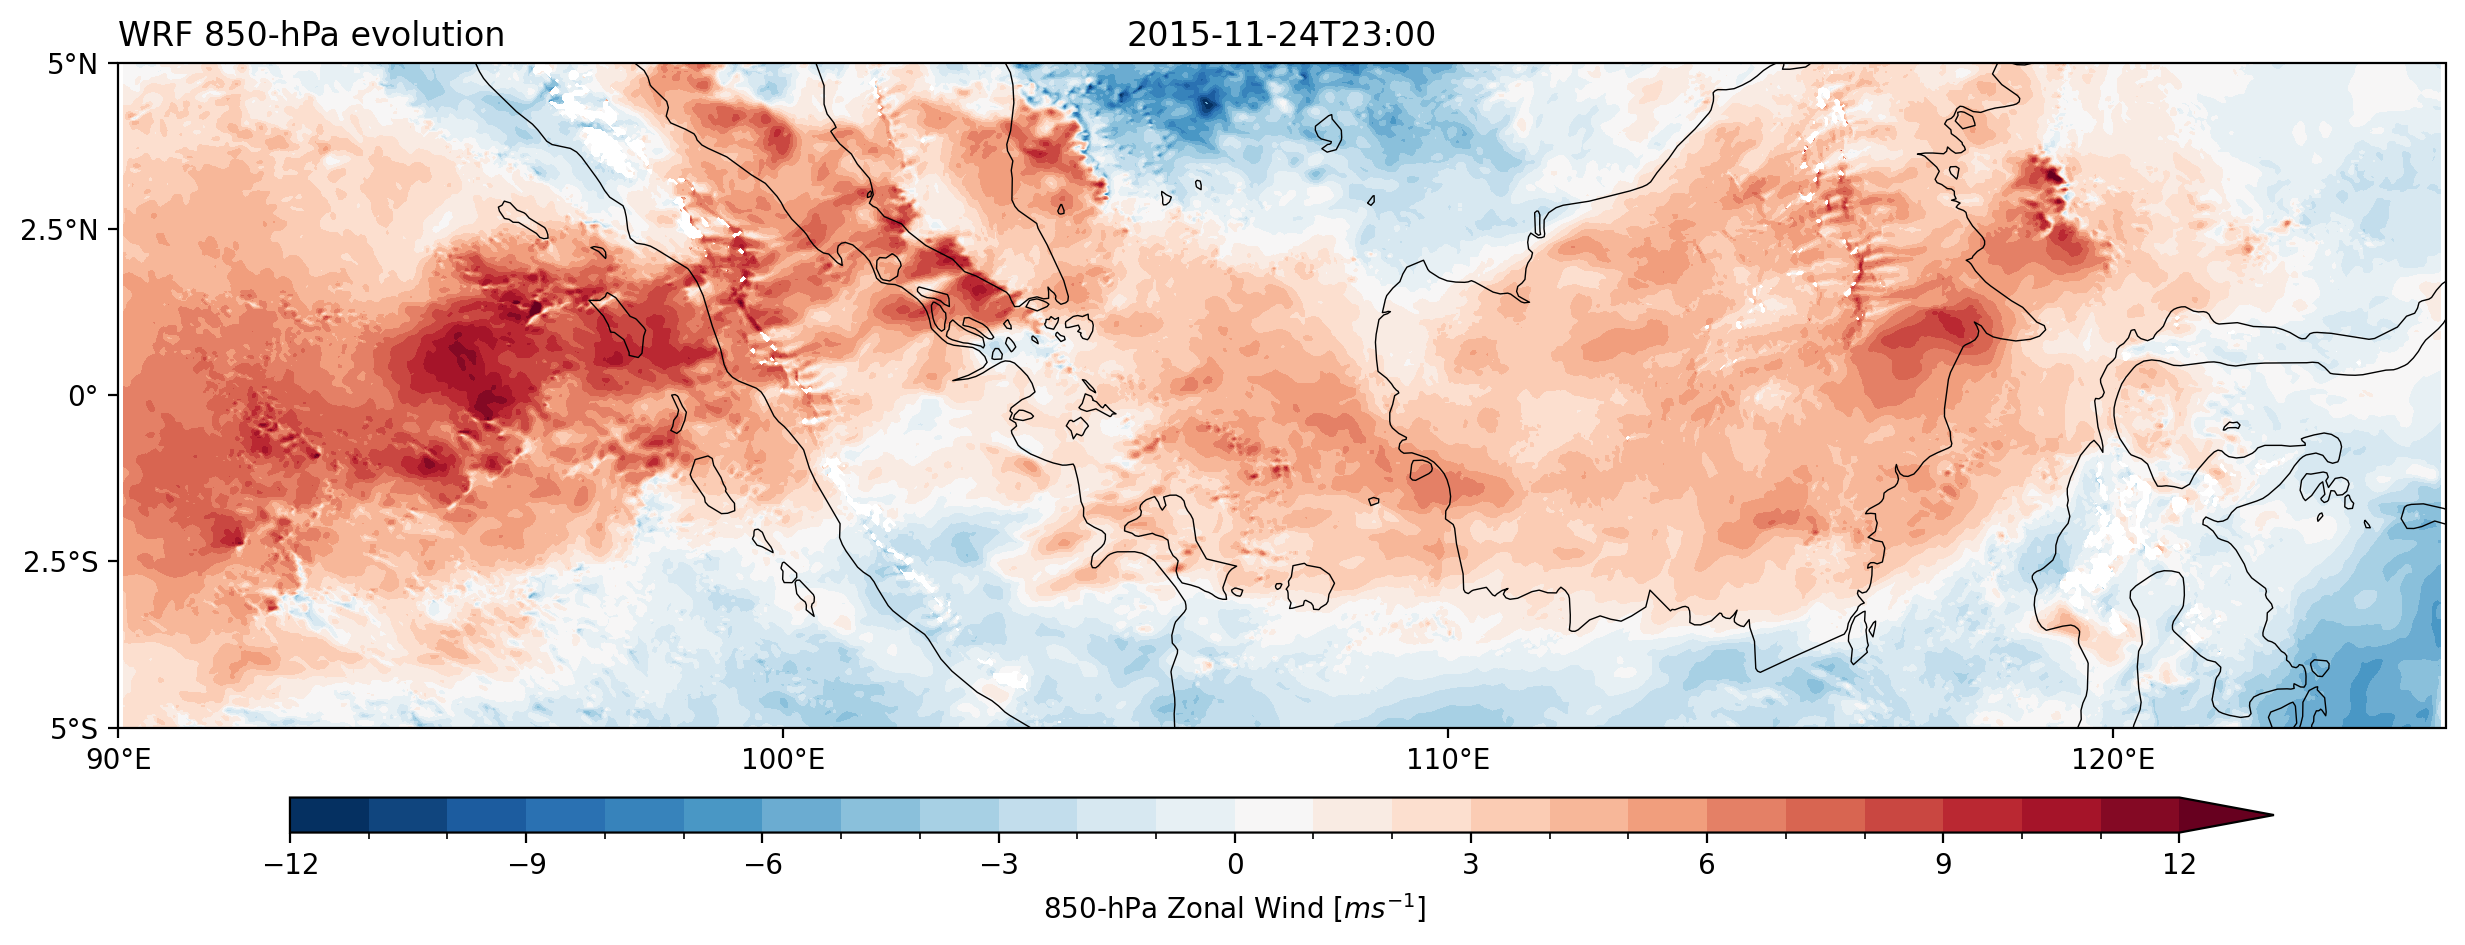

In [46]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
lat_avg_bound = [-5,5]
# Data
x = da_d02_U850[36:60,...].where(
    (da_d02_U850[36:60,...].XLAT>lat_avg_bound[0]) & (da_d02_U850[36:60,...].XLAT<lat_avg_bound[1]),
    drop=True)    # mm/day

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='k', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [-12,13]
dl = 1


cf = x[0,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='max',
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
    )


ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('850-hPa Zonal Wind [$m s^{-1}$]')

for i in range(24):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='max',
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
        ) 
    ax1.set_title('WRF 850-hPa evolution',loc='left')
    ax1.set_title(np.datetime_as_string(x.XTIME[i],unit='m'))
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    plt.savefig('plots/WRF_U_'+np.datetime_as_string(x.XTIME[i],unit='m')+'.png',dpi=300)
